### 1. Naive process for model building.

- Model building involves understanding the data.
- It's not just to plug few calls using powerfull ML libraries.

In [10]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt


#### We will use two datasets
- Train data: Used to make our model 'learn'
- Test data: Used to confirm that we can predict new data using the model


In [11]:
# Loads the data for train and test.
train_orig = pd.read_csv('data/train.csv')
test_orig = pd.read_csv('data/test.csv')
test_orig.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Unnamed: 12
0,1284,3,"Abbott, Master. Eugene Joseph",male,13.0,0,2,C.A. 2673,20.2500,NaN,S,0,NaN
1,1237,3,"Abelseth, Miss. Karen Marie",female,16.0,0,0,348125,7.6500,NaN,S,1,NaN
2,949,3,"Abelseth, Mr. Olaus Jorgensen",male,25.0,0,0,348122,7.6500,F G63,S,1,NaN
3,1143,3,"Abrahamsson, Mr. Abraham August Johannes",male,20.0,0,0,SOTON/O2 3101284,7.9250,NaN,S,1,NaN
4,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1,NaN


In [12]:
# Remove the last column, since we are not using it.
test_orig = test_orig.iloc[: , :-1]
test_orig.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1284,3,"Abbott, Master. Eugene Joseph",male,13.0,0,2,C.A. 2673,20.25,NaN,S,0
1,1237,3,"Abelseth, Miss. Karen Marie",female,16.0,0,0,348125,7.65,NaN,S,1
2,949,3,"Abelseth, Mr. Olaus Jorgensen",male,25.0,0,0,348122,7.65,F G63,S,1


In [13]:
train = train_orig.copy() 
test =  test_orig.copy()

dataset_list = [train, test]

# Define the 'Features' we are going to use to make predictions.
for dataset in dataset_list:
    # Fix cabin feature
    dataset['Has_Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    # Family = siblings + parents + you
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    # New feature traveling alone
    dataset['TravelingAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'TravelingAlone'] = 1
    # Fill the embarked=null with most common.
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    # Fill the null fares with the median fare
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    # generate random numbers around mean for age (mixing genders here)
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    # Spreading one standard deviation.
    new_age_values = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = new_age_values
    dataset['Age'] = dataset['Age'].astype(int)
    # If not know fill with male
    dataset['Sex'] = dataset['Sex'].fillna('male')
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    dataset.loc[(dataset['Age'] <= 12), 'Age'] = 0
    dataset.loc[(dataset['Age'] > 12) & (dataset['Age'] <= 24), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 24) & (dataset['Age'] <= 36), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 36) & (dataset['Age'] <= 48), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 48), 'Age'] = 4

train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,FamilySize,TravelingAlone
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,7.2500,NaN,0,0,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,3,1,0,PC 17599,71.2833,C85,1,1,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,2,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,53.1000,C123,0,1,2,0
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,8.0500,NaN,0,0,1,1
5,6,0,3,"Moran, Mr. James",1,3,0,0,330877,8.4583,NaN,2,0,1,1
6,7,0,1,"McCarthy, Mr. Timothy J",1,4,0,0,17463,51.8625,E46,0,1,1,1
7,8,0,3,"Palsson, Master. Gosta Leonard",1,0,3,1,349909,21.0750,NaN,0,0,5,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,2,0,2,347742,11.1333,NaN,0,0,3,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,1,1,0,237736,30.0708,NaN,1,0,2,0


In [14]:
# In the naive model, we dont try to understand the data.
# So these fields seem useless and we remove them remove them.
fields_to_drop = ['Name', 'PassengerId', 'Ticket', 'Cabin', 'SibSp']
train_clean = train.drop(fields_to_drop, axis = 1)
test_clean  = test.drop(fields_to_drop, axis = 1)


In [15]:
train_clean.isnull().any()

Survived          False
Pclass            False
Sex               False
Age               False
Parch             False
Fare              False
Embarked          False
Has_Cabin         False
FamilySize        False
TravelingAlone    False
dtype: bool

In [16]:
# --- Five Steps ---

# Step 1: Allocate the model building object for the model we
#.        want to use.
tree_model = tree.DecisionTreeClassifier(max_depth = 3)


# Step 2: Separate the columns to learn from (predictors_train)
# and the predicted value ('Survided')
train_X = train_clean.drop(['Survived'], axis=1) # Also called X
train_y = train_clean["Survived"] # Also called y


# Step 3: Train the model
model = tree_model.fit(train_X, train_y)


# Step 4: Make predictions with the model for the elements in the test data.
test_X = test_clean.drop(['Survived'], axis=1)
test_y = test_clean["Survived"]


# Step 5 Report model performance results.
accuracy = model.score(test_X, test_y) 
print('Model Accuracy is {0:.2F}%'.format(accuracy * 100))

Model Accuracy is 75.12%


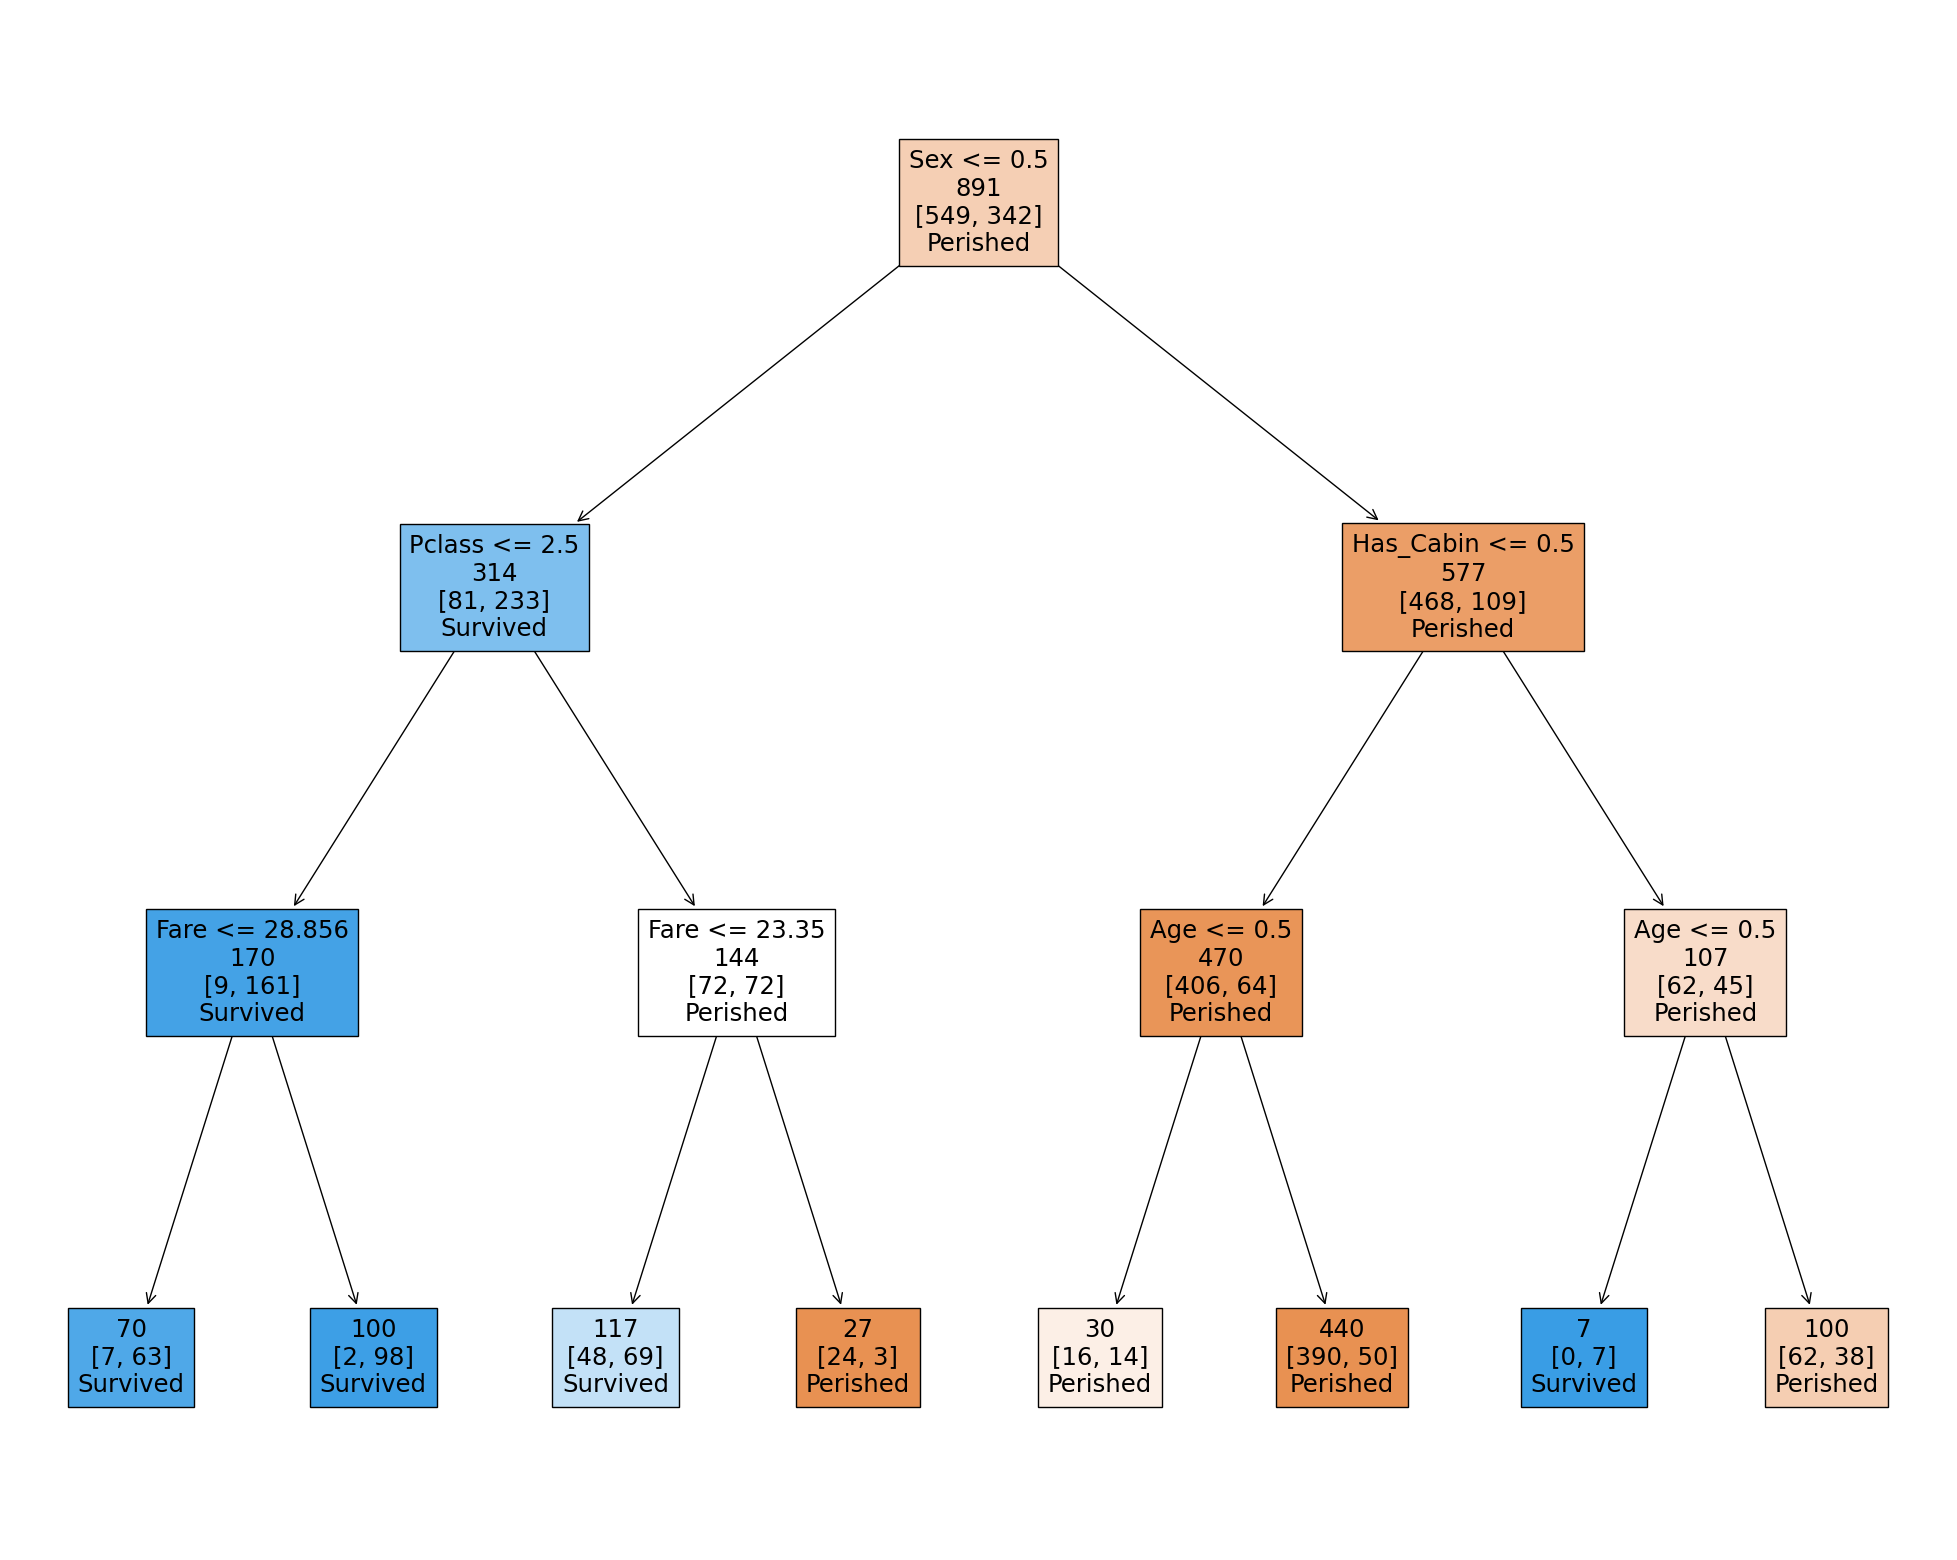

In [8]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(
    tree_model, 
    feature_names=train_X.columns,  
    class_names=["Perished", "Survived"] ,
    filled=True, impurity=False, node_ids=False, proportion=False, label='none')

In [9]:
fature_names = [str(x) for x in train_X.columns]
text_representation = tree.export_text(tree_model, feature_names=fature_names)
print(text_representation)

|--- Sex <= 0.50
|   |--- Pclass <= 2.50
|   |   |--- Fare <= 28.86
|   |   |   |--- class: 1
|   |   |--- Fare >  28.86
|   |   |   |--- class: 1
|   |--- Pclass >  2.50
|   |   |--- Fare <= 23.35
|   |   |   |--- class: 1
|   |   |--- Fare >  23.35
|   |   |   |--- class: 0
|--- Sex >  0.50
|   |--- Has_Cabin <= 0.50
|   |   |--- Age <= 0.50
|   |   |   |--- class: 0
|   |   |--- Age >  0.50
|   |   |   |--- class: 0
|   |--- Has_Cabin >  0.50
|   |   |--- Age <= 0.50
|   |   |   |--- class: 1
|   |   |--- Age >  0.50
|   |   |   |--- class: 0

